<a href="https://colab.research.google.com/github/SmaranikaSethy/Air_Quality_Index_Project/blob/main/AQI_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()


Saving PRSA_DATA.zip to PRSA_DATA.zip


In [2]:
import zipfile
import os

with zipfile.ZipFile("PRSA_DATA.zip", 'r') as zip_ref:
    zip_ref.extractall("data")

os.listdir("data")

['PRSA_DATA']

In [3]:
import pandas as pd
import glob

# Load all CSVs
files = glob.glob("data/PRSA_DATA/*.csv")

dfs = []
for file in files:
    df = pd.read_csv(file)
    dfs.append(df)

# Merge into one dataset
data = pd.concat(dfs, ignore_index=True)

print("Dataset Shape:", data.shape)
data.head()


Dataset Shape: (210384, 18)


,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
1,2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
2,3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
3,4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
4,5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin


In [4]:
def compute_aqi(pm25):
    if pm25 <= 12:
        return 50*(pm25/12)
    elif pm25 <= 35.4:
        return 50 + (pm25-12)*(50/(35.4-12))
    elif pm25 <= 55.4:
        return 100 + (pm25-35.4)*(50/(55.4-35.4))
    elif pm25 <= 150.4:
        return 150 + (pm25-55.4)*(50/(150.4-55.4))
    elif pm25 <= 250.4:
        return 200 + (pm25-150.4)*(100/(250.4-150.4))
    else:
        return 300 + (pm25-250.4)*(200/(500.4-250.4))

data['AQI'] = data['PM2.5'].apply(compute_aqi)


In [5]:
def category(aqi):
    if aqi <= 50:
        return "Good"
    elif aqi <= 100:
        return "Satisfactory"
    elif aqi <= 200:
        return "Moderate"
    elif aqi <= 300:
        return "Poor"
    elif aqi <= 400:
        return "Very Poor"
    else:
        return "Severe"

data['AQI_Level'] = data['AQI'].apply(category)
data[['PM2.5','AQI','AQI_Level']].head()


,PM2.5,AQI,AQI_Level
0,4.0,16.666667,Good
1,8.0,33.333333,Good
2,7.0,29.166667,Good
3,6.0,25.000000,Good
4,3.0,12.500000,Good


In [6]:
features = ['PM2.5','PM10','SO2','NO2','CO','O3','TEMP','PRES','DEWP','WSPM']
X = data[features]
y = data['AQI_Level']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)


In [8]:
data = data.dropna(subset=['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3'])
data = data.ffill()

print("After cleaning:", data.shape)


After cleaning: (191613, 20)


🌲 Random Forest Results:
Accuracy (Train): 0.9999920779529431
Accuracy (Test): 0.9999762340471041
              precision    recall  f1-score   support

        Good       1.00      1.00      1.00     12659
    Moderate       1.00      1.00      1.00     38673
        Poor       1.00      1.00      1.00      8804
Satisfactory       1.00      1.00      1.00     18599
      Severe       1.00      1.00      1.00      2556
   Very Poor       1.00      1.00      1.00      2863

    accuracy                           1.00     84154
   macro avg       1.00      1.00      1.00     84154
weighted avg       1.00      1.00      1.00     84154


🚀 XGBoost Results:
Accuracy (Train): 1.0
Accuracy (Test): 0.9960310858663878
              precision    recall  f1-score   support

        Good       1.00      0.99      0.99     12659
    Moderate       1.00      1.00      1.00     38673
        Poor       0.99      1.00      0.99      8804
Satisfactory       1.00      1.00      1.00     18599
      Seve

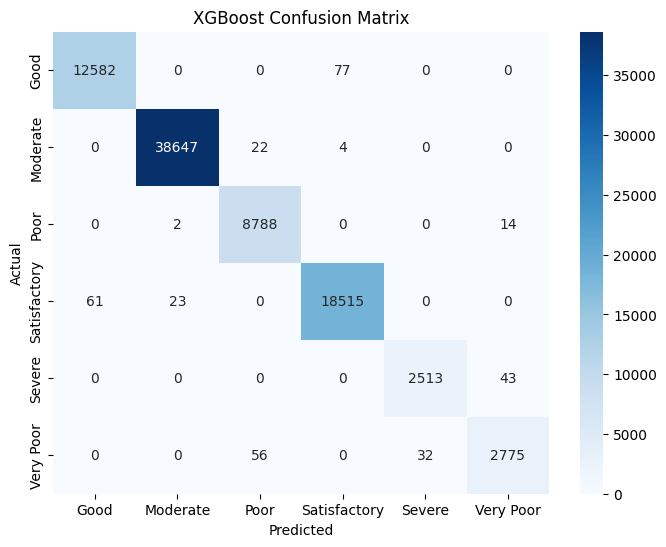

In [9]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Encode labels
encoder = LabelEncoder()
y_train_enc = encoder.fit_transform(y_train)
y_test_enc = encoder.transform(y_test)

# Add small noise to reduce overfitting
X_train_noisy = X_train + np.random.normal(0, 0.01, X_train.shape)
X_test_noisy = X_test + np.random.normal(0, 0.01, X_test.shape)

# ---- Regularized Random Forest ----
rf = RandomForestClassifier(
    n_estimators=120,       # fewer trees
    max_depth=10,           # limit tree depth
    min_samples_split=10,   # minimum samples to split
    min_samples_leaf=4,     # minimum samples per leaf
    max_features='sqrt',    # use subset of features
    random_state=42
)
rf.fit(X_train_noisy, y_train_enc)

# ---- Regularized XGBoost ----
xgb = XGBClassifier(
    n_estimators=180,
    max_depth=7,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.5,    # L2 regularization
    reg_alpha=0.5,     # L1 regularization
    eval_metric='mlogloss',
    random_state=42
)
xgb.fit(X_train_noisy, y_train_enc)

# ---- Predictions ----
rf_pred_enc = rf.predict(X_test_noisy)
xgb_pred_enc = xgb.predict(X_test_noisy)

rf_pred = encoder.inverse_transform(rf_pred_enc)
xgb_pred = encoder.inverse_transform(xgb_pred_enc)
y_test_labels = encoder.inverse_transform(y_test_enc)

# ---- Train predictions for comparison ----
rf_train_pred_enc = rf.predict(X_train_noisy)
xgb_train_pred_enc = xgb.predict(X_train_noisy)
rf_train_pred = encoder.inverse_transform(rf_train_pred_enc)
xgb_train_pred = encoder.inverse_transform(xgb_train_pred_enc)
y_train_labels = encoder.inverse_transform(y_train_enc)

# ---- Evaluation ----
print("🌲 Random Forest Results:")
print("Accuracy (Train):", accuracy_score(y_train_labels, rf_train_pred))
print("Accuracy (Test):", accuracy_score(y_test_labels, rf_pred))
print(classification_report(y_test_labels, rf_pred))

print("\n🚀 XGBoost Results:")
print("Accuracy (Train):", accuracy_score(y_train_labels, xgb_train_pred))
print("Accuracy (Test):", accuracy_score(y_test_labels, xgb_pred))
print(classification_report(y_test_labels, xgb_pred))

# ---- Cross-validation ----
y_full_enc = encoder.fit_transform(y)
xgb_cv_scores = cross_val_score(xgb, X, y_full_enc, cv=5, scoring='accuracy')
print("\nCross-Validation Accuracies:", xgb_cv_scores)
print("CV Mean:", xgb_cv_scores.mean())
print("CV Std Dev:", xgb_cv_scores.std())

# ---- Confusion Matrix ----
plt.figure(figsize=(8,6))
cm = confusion_matrix(y_test_labels, xgb_pred, labels=encoder.classes_)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('XGBoost Confusion Matrix')
plt.show()
